In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import gym
from gym.envs.registration import register

# ACS2 in Frozen Lake

About the environment
> The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

In [2]:
fl_env = gym.make('FrozenLake-v0')

# Reset the state
state = fl_env.reset()

# Render the environment
fl_env.render()


SFFF
FHFH
FFFH
HFFG


Each state might get following possible values: `{S, F, H, G}` which, refers to
```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
```

In case of interacting with environment agent cant perform 4 action which map as follow:
- 0 - left
- 1 - down
- 2 - right
- 3 - up

> FrozenLake-v0 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.

We will also define a second version of the same environment but with `slippery=False` parameters. That make it more deterministic.

In [3]:
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78,  # optimum = .8196
)

fl_ns_env = gym.make('FrozenLakeNotSlippery-v0')

# Reset the state
state = fl_ns_env.reset()

# Render the environment
fl_ns_env.render()


SFFF
FHFH
FFFH
HFFG


## ACS2

In [5]:
# Import PyALCS code from local path
import sys, os
sys.path.append(os.path.abspath('../../..'))

from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

CLASSIFIER_LENGTH = 16  # Because we are operating in 4x4 grid
POSSIBLE_ACTIONS = fl_env.action_space.n  # 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Encoding perception
The only information back from the environment is the current agent position (not it's perception). Therefore our agent task will be to predicit where it will land after executing each action.

To do so we will represent state as a one-hot encoded vector.

In [12]:
class FrozenLakeAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        genotype = ['0' for i in range(CLASSIFIER_LENGTH)]
        genotype[phenotype] = 'X'
        return ''.join(genotype)

`X` corresponds to current agent position. State 4 is encoded as follows:

In [13]:
FrozenLakeAdapter().to_genotype(4)

'0000X00000000000'

### Environment metrics
We will also need a function for evaluating if agent finished succesfuly a trial

In [16]:
from lcs.metrics import population_metrics


# We assume if the final state was with number 15 that the algorithm found the reward. Otherwise not
def fl_metrics(pop, env):
    metrics = {
        'found_reward': env.env.s == 15,
    }
    
    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

### Performance evaluation

In [17]:
def print_performance(population, metrics):
    population.sort(key=lambda cl: -cl.fitness)
    population_count = len(population)
    reliable_count = len([cl for cl in population if cl.is_reliable()])
    successful_trials = sum(m['found_reward'] for m in metrics)

    print("Number of classifiers: {}".format(population_count))
    print("Number of reliable classifiers: {}".format(reliable_count))
    print("Percentage of successul trials: {:.2f}%".format(successful_trials / EXPLOIT_TRIALS  * 100))
    print("\nTop 10 classifiers:")
    for cl in population[:10]:
        print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f} \texp: {}".format(cl, cl.q, cl.r, cl.ir, cl.exp))

In [18]:
def plot_success_trials(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    success = [m['found_reward'] for m in metrics]

    ax.plot(trials, success)
    ax.set_title("Successful Trials")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Agent found reward")

In [19]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['numerosity'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='all')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

In [20]:
def plot_performance(metrics):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle('Performance Visualization')
    
    ax1 = plt.subplot(221)
    plot_success_trials(metrics, ax1)
    
    ax2 = plt.subplot(222)
    plot_population(metrics, ax2)
    
    plt.show()

### Default ACS2 configuration
Right now we are ready to configure the ACS2 agent providing some defaults

In [21]:
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=POSSIBLE_ACTIONS,
    environment_adapter=FrozenLakeAdapter(),
    metrics_trial_frequency=1,
    user_metrics_collector_fcn=fl_metrics,
    theta_i=0.3,
    epsilon=0.7)

print(cfg)

ACS2Configuration:
	- Classifier length: [16]
	- Number of possible actions: [4]
	- Classifier wildcard: [#]
	- Environment adapter function: [<__main__.FrozenLakeAdapter object at 0x110cd5a90>]
	- Do GA: [False]
	- Do subsumption: [True]
	- Do Action Planning: [False]
	- Beta: [0.05]
	- ...
	- Epsilon: [0.7]
	- U_max: [100000]


## Experiments

In [22]:
EXPLORE_TRIALS = 2000
EXPLOIT_TRIALS = 100


def perform_experiment(cfg, env):
    # explore phase
    agent = ACS2(cfg)
    population_explore, metrics_explore = agent.explore(env, EXPLORE_TRIALS)
    
    # exploit phase, reinitialize agent with population above
    agent = ACS2(cfg, population=population_explore)
    population_exploit, metrics_exploit = agent.exploit(env, EXPLOIT_TRIALS)
    
    return (population_explore, metrics_explore), (population_exploit, metrics_exploit)

### FrozenLake-v0 environment (baseline)

In [23]:
%%time
explore_results, exploit_results = perform_experiment(cfg, fl_env) 

CPU times: user 56 s, sys: 460 ms, total: 56.4 s
Wall time: 59.7 s


Learn some behaviour during exploration phase

In [24]:
# exploration
print_performance(explore_results[0], explore_results[1])

Number of classifiers: 457
Number of reliable classifiers: 0
Percentage of successul trials: 40.00%

Top 10 classifiers:
##############X0-2-##############0X @ 0x110e80048 	q: 0.67 	r: 0.40 	ir: 0.31 	exp: 31
#0############X0-2-##############0X @ 0x110f61f98 	q: 0.63 	r: 0.40 	ir: 0.31 	exp: 30
######0#######X0-2-##############0X @ 0x1110e7358 	q: 0.52 	r: 0.38 	ir: 0.29 	exp: 11
##########0###X#-2-##########X###0# @ 0x110de1278 	q: 0.49 	r: 0.40 	ir: 0.31 	exp: 18
#0########0###X#-2-##########X###0# @ 0x1110a1e48 	q: 0.47 	r: 0.40 	ir: 0.31 	exp: 18
#############0X#-1-#############X0# @ 0x110e809e8 	q: 0.45 	r: 0.33 	ir: 0.28 	exp: 35
##############X0-1-##############0X @ 0x110eb37f0 	q: 0.43 	r: 0.33 	ir: 0.28 	exp: 32
########0#0###X#-3-##########X###0# @ 0x110eb3128 	q: 0.44 	r: 0.25 	ir: 0.23 	exp: 39
##########0###X#-3-##########X###0# @ 0x110eb30b8 	q: 0.42 	r: 0.25 	ir: 0.23 	exp: 38
#0############X0-1-##############0X @ 0x110ee7b00 	q: 0.35 	r: 0.27 	ir: 0.22 	exp: 24


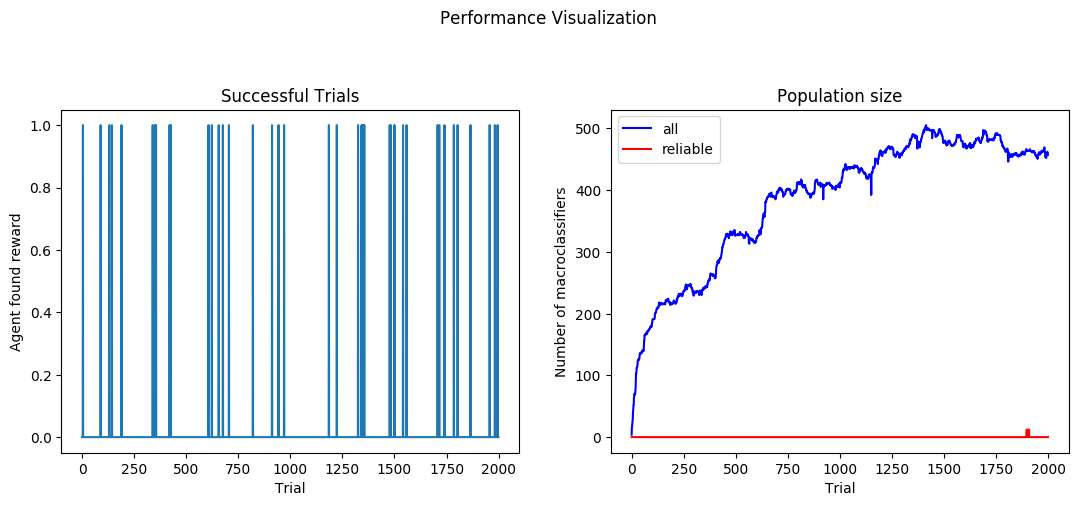

In [25]:
plot_performance(explore_results[1])

Metrics from exploitation

In [26]:
# exploitation
print_performance(exploit_results[0], exploit_results[1])

Number of classifiers: 457
Number of reliable classifiers: 0
Percentage of successul trials: 12.00%

Top 10 classifiers:
##############X0-2-##############0X @ 0x110e80048 	q: 0.67 	r: 0.40 	ir: 0.31 	exp: 31
#0############X0-2-##############0X @ 0x110f61f98 	q: 0.63 	r: 0.40 	ir: 0.31 	exp: 30
######0#######X0-2-##############0X @ 0x1110e7358 	q: 0.52 	r: 0.38 	ir: 0.29 	exp: 11
##########0###X#-2-##########X###0# @ 0x110de1278 	q: 0.49 	r: 0.40 	ir: 0.31 	exp: 18
#0########0###X#-2-##########X###0# @ 0x1110a1e48 	q: 0.47 	r: 0.40 	ir: 0.31 	exp: 18
#############0X#-1-#############X0# @ 0x110e809e8 	q: 0.45 	r: 0.33 	ir: 0.28 	exp: 35
##############X0-1-##############0X @ 0x110eb37f0 	q: 0.43 	r: 0.33 	ir: 0.28 	exp: 32
########0#0###X#-3-##########X###0# @ 0x110eb3128 	q: 0.44 	r: 0.25 	ir: 0.23 	exp: 39
##########0###X#-3-##########X###0# @ 0x110eb30b8 	q: 0.42 	r: 0.25 	ir: 0.23 	exp: 38
#0############X0-1-##############0X @ 0x110ee7b00 	q: 0.35 	r: 0.27 	ir: 0.22 	exp: 24


### FrozenLakeNotSlippery-v0 environment

In [27]:
%%time
explore_results_2, exploit_results_2 = perform_experiment(cfg, fl_ns_env)

CPU times: user 12.8 s, sys: 152 ms, total: 12.9 s
Wall time: 13.4 s


In [28]:
# exploration
print_performance(explore_results_2[0], explore_results_2[1])

Number of classifiers: 109
Number of reliable classifiers: 106
Percentage of successul trials: 204.00%

Top 10 classifiers:
##############X0-2-##############0X @ 0x113765cf8 	q: 1.00 	r: 1.00 	ir: 1.00 	exp: 203
#############X0#-2-#############0X# @ 0x113789c18 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 247
##########X###0#-1-##########0###X# @ 0x113714748 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 158
##############X#-1-################ @ 0x1137bbac8 	q: 1.00 	r: 0.94 	ir: 0.00 	exp: 105
#########X###0##-1-#########0###X## @ 0x113789048 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 370
#########X0#####-2-#########0X##### @ 0x1137bb6d8 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 169
#############X##-1-################ @ 0x1137bba58 	q: 1.00 	r: 0.89 	ir: 0.00 	exp: 121
#00######0###0X#-0-#############X0# @ 0x1137bb080 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 92
##########0###X#-3-##########X###0# @ 0x113a6b0b8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 110
#00##########0X#-0-#############X0# @ 0x1137892e8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 9

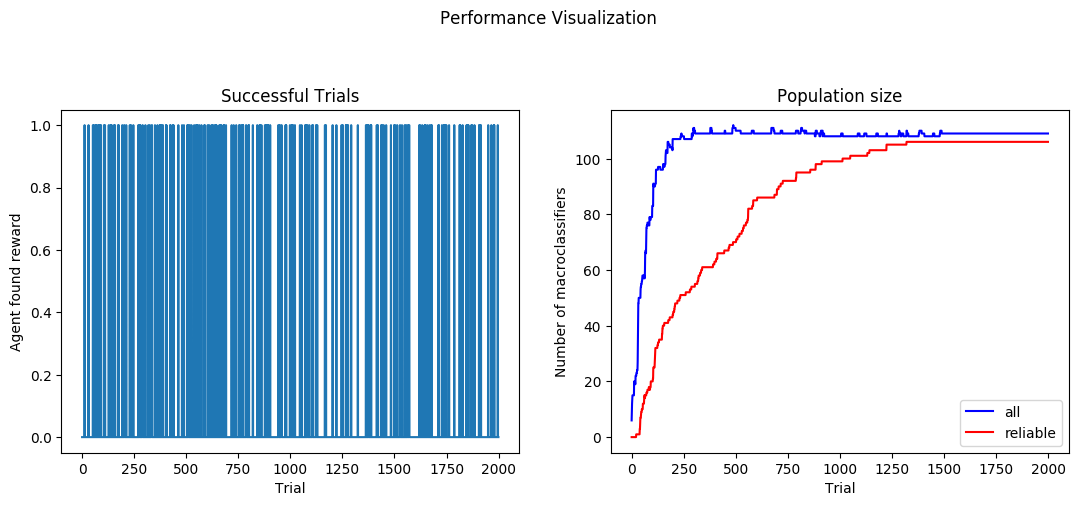

In [29]:
plot_performance(explore_results_2[1])

In [30]:
# exploitation
print_performance(exploit_results_2[0], exploit_results_2[1])

Number of classifiers: 109
Number of reliable classifiers: 106
Percentage of successul trials: 100.00%

Top 10 classifiers:
##############X0-2-##############0X @ 0x113765cf8 	q: 1.00 	r: 1.00 	ir: 1.00 	exp: 203
#############X0#-2-#############0X# @ 0x113789c18 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 247
##########X###0#-1-##########0###X# @ 0x113714748 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 158
##############X#-1-################ @ 0x1137bbac8 	q: 1.00 	r: 0.94 	ir: 0.00 	exp: 105
#########X###0##-1-#########0###X## @ 0x113789048 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 370
#########X0#####-2-#########0X##### @ 0x1137bb6d8 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 169
#############X##-1-################ @ 0x1137bba58 	q: 1.00 	r: 0.89 	ir: 0.00 	exp: 121
#00######0###0X#-0-#############X0# @ 0x1137bb080 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 92
##########0###X#-3-##########X###0# @ 0x113a6b0b8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 110
#00##########0X#-0-#############X0# @ 0x1137892e8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 9

## Comparison

In [31]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['numerosity'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='all')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

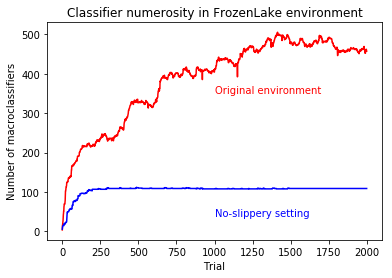

In [32]:
original = explore_results[1]
modified = explore_results_2[1]

ax = plt.gca()

trials = [m['trial'] for m in original]

original_numerosity = [m['numerosity'] for m in original]
modified_numerosity = [m['numerosity'] for m in modified]

ax.plot(trials, original_numerosity, 'r')
ax.text(1000, 350, "Original environment", color='r')

ax.plot(trials, modified_numerosity, 'b')
ax.text(1000, 40, 'No-slippery setting', color='b')


ax.set_title('Classifier numerosity in FrozenLake environment')
ax.set_xlabel('Trial')
ax.set_ylabel('Number of macroclassifiers')

plt.show()